In [ ]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os 
from pathlib import Path
import re

In [ ]:
plt.rcParams['figure.dpi'] = 150 # better resolution when showing and saving
plt.rcParams["savefig.dpi"] = 150
plt.rcParams['font.size'] = 15

In [ ]:
LN = Path(os.getenv("TALLIS")) / "Ling-Networks"

In [ ]:
SUF_MAP = {
    "": "Low Homoplasy",
    "-hihp": "High Homoplasy"
}
METHODS = ["ASTRAL(9,5)", "ASTRAL(10,5)", "MP4", "GA", "COV", "TRUE-CAMUS"]
FACTORS = ["1.0", "2.0", "4.0"]

In [ ]:
scorepathre = re.compile(r'inference_outputs-(?P<factor>[0-9].[05])(?P<suf>(-[a-z]+)?)/(?P<poly>\S+)_borrowing')
def get_data(score_path):
    matched = scorepathre.search(score_path)
    if matched is None:
        return None
    df = pd.read_csv(score_path)
    method = None
    for _method in METHODS:
        if _method in score_path:
            method = _method 
    df['factor'] = matched.group('factor')
    df['poly'] = matched.group('poly')
    df['suf'] = SUF_MAP[matched.group('suf')]
    df['method'] = method
    return df

In [ ]:
from itertools import chain
all_score_paths = chain(
    (LN / "outputs").glob("*/*/*/CAMUS/underlyingtree_scores.csv"),
)

df_net = None

for score_path in all_score_paths: 
    if "COV" in str(score_path):
        continue
    print(score_path)
    res = get_data(str(score_path))
    if df_net is None:
        df_net = res
    else: 
        df_net = pd.concat([df_net, res], ignore_index=True)
df_net['type'] = 'NET'

In [ ]:
from itertools import chain
all_score_paths = chain(
    (LN / "outputs").glob("*/*/*/underlyingtree_scores.csv")
)
df_tree = None

for score_path in all_score_paths: 
    if "COV" in str(score_path):
        continue
    print(score_path)
    res = get_data(str(score_path))
    if df_tree is None:
        df_tree = res
    elif res is not None: 
        df_tree = pd.concat([df_tree, res], ignore_index=True)
    else:
        print(f"HEY {score_path=} is None")
df_tree['type'] = 'TREE'

In [ ]:
df_tree.head()

In [ ]:
df_net.head()

In [ ]:
print(len(df_tree), len(df_net))

In [ ]:
df = pd.concat([df_tree, df_net], ignore_index=True)

In [ ]:
def tree_net_comparison(
    y: str,
    ylabel: str,
    title: str,
    tree_first: bool = False,
):
    fig, ax = plt.subplots(1,1)
    sns.barplot(
        data=df_net if not tree_first else df_tree, 
        y=y,
        x = 'factor',
        hue='method',
        order = ["1.0", "2.0", "4.0"],
        ax=ax,
        palette= sns.color_palette()  if not tree_first else sns.color_palette(palette="pastel"),
        errorbar='se',
    )
    sns.barplot(
        data=df_tree if not tree_first else df_net, 
        y=y,
        x = 'factor',
        hue='method',
        order = ["1.0", "2.0", "4.0"],
        ax=ax,
        palette=sns.color_palette(palette="pastel") if not tree_first else sns.color_palette() ,
        errorbar='se',
    )
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(
        by_label.values(),
        by_label.keys(), 
        ncol=3, 
        # loc = 'lower left',
        prop={'size': 10},
    )
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    fig.show()
    fig.savefig(LN / "figs" / f"{y}-by-method.png", bbox_inches='tight')
    return ax

In [ ]:
tree_net_comparison('js', 'Jaccard Similarity', 'Jaccard Similarity by method')
tree_net_comparison('cd', 'Clade Distance', 'Clade Distance by method')
tree_net_comparison('fn', 'FN', 'FN by method', tree_first=True)
tree_net_comparison('fp', 'FP', 'FP by method', tree_first=True)

In [ ]:
ax = plt.subplot()
sns.barplot(
    data=df_net[df_net["method"] == "TRUE-CAMUS"], 
    y='cd',
    x = 'factor',
    hue='edges',
    order = ["1.0", "2.0", "4.0"],
    ax=ax,
    palette=sns.color_palette("Set2")
)
ax.set_ylabel("Clade Distance")
ax.set_title("Clade Distance by edges in model network on true trees")
plt.savefig(LN / "figs" / "cd-by-edge.png", bbox_inches='tight')

In [ ]:
ax = plt.subplot()
sns.barplot(
    data=df_net[df_net["method"] == "TRUE-CAMUS"], 
    y= 'js',
    x = 'factor',
    hue= 'edges',
    order = ["1.0", "2.0", "4.0"],
    ax=ax,
    palette=sns.color_palette("Set2")
)
ax.set_ylabel("Jaccard Similarity")
ax.set_title("Jaccard sim., edges in model net, true trees")
plt.savefig(LN / "figs" / "js-by-edge.png", bbox_inches='tight')

In [ ]:
ax = plt.subplot()
sns.barplot(
    data=df_net[df_net["method"] == "TRUE-CAMUS"], 
    y= 'js',
    x = '',
    hue= 'edges',
    order = ["1.0", "2.0", "4.0"],
    ax=ax,
    palette=sns.color_palette("Set2")
)
ax.set_ylabel("Jaccard Similarity")
ax.set_title("Jaccard sim., edges in model net, true trees")
plt.savefig(LN / "figs" / "js-by-edge.png", bbox_inches='tight')

## Parse CAMUS logs

In [8]:
logpathre = re.compile(r'inference_outputs-(?P<factor>[0-9].[05])(?P<suf>(-[a-z]+)?)/(?P<poly>\S+)_borrowing')
totquartetre = re.compile(r'(?P<tgt>\d+) gene trees provided')
newquartetre = re.compile(r'(?P<tgt>\d+) new quartet trees')
dpscorere = re.compile(r'dp scored (?P<tgt>\d+) at root')
newedgere = re.compile(r'(?P<tgt>\d+) edges identified')
lognamere = re.compile(r'(?P<xedges>\d+)-_?(?P<tree>\d+)_(?P<replica>\d+)')

def get_maybe_re(reg, inp):
    m = reg.search(inp)
    return float(m.group('tgt')) if m is not None else None

def parse_camus_log(log_path):
    contents = open(log_path, "r").read()
    return get_maybe_re(totquartetre, contents), get_maybe_re(newquartetre, contents),\
        get_maybe_re(dpscorere, contents), get_maybe_re(newedgere, contents)

def parse_camus_filename(log_path):
    m = lognamere.search(log_path)
    if m is None:
        return m 
    return m.group('xedges'), m.group('tree'), m.group('replica')


def get_camus_log_data(log_path):
    matched = logpathre.search(log_path)
    if matched is None:
        return None
    method = log_path.split('/')[-4]
    tot_quartets, new_quartets, dp_score, extra_edges = parse_camus_log(log_path)
    xedges, tree, replica= parse_camus_filename(log_path)

    return {
        'tree': tree,
        'replica': replica,
        'actual_extra_edges': xedges,
        'factor': matched.group('factor'),
        'poly': matched.group('poly'),
        'suf': SUF_MAP[matched.group('suf')],
        'method': method if "TRUE-CAMUS" not in log_path else "True Tree",
        'tree_q_score': (tot_quartets - new_quartets) / tot_quartets,
        'net_q_score' : (tot_quartets - new_quartets + dp_score) / tot_quartets,
        'tot_quartets' : tot_quartets,
        'extra_edges' : extra_edges,
    }

In [9]:
get_camus_log_data("/projects/illinois/eng/cs/warnow/zxliu2/Ling-Networks/outputs/inference_outputs-2.0/high_borrowing/ASTRAL(10,5)/CAMUS/logs/high1-_13_1-output.log")

{'tree': '13',
 'replica': '1',
 'actual_extra_edges': '1',
 'factor': '2.0',
 'poly': 'high',
 'suf': 'Low Homoplasy',
 'method': 'ASTRAL(10,5)',
 'tree_q_score': 0.99388557286359,
 'net_q_score': 0.9996117824040375,
 'tot_quartets': 20607.0,
 'extra_edges': 3.0}

In [10]:
all_score_paths = (LN / "outputs").glob("**/CAMUS/logs/*.log")

data = []

for score_path in all_score_paths: 
    if "COV" in str(score_path):
        continue
    # print(str(score_path))
    res = get_camus_log_data(str(score_path))
    if res is not None:
        data.append(res)
    else:
        print(f"{score_path=} returned NONE!")
df_logs = pd.DataFrame.from_records(data)

In [ ]:
print(len(df_logs))

In [11]:
df_logs.head()

,tree,replica,actual_extra_edges,factor,poly,suf,method,tree_q_score,net_q_score,tot_quartets,extra_edges
0,7,1,1,4.0,high,Low Homoplasy,GA,1.000000,1.000000,9433.0,0.0
1,6,1,2,4.0,high,Low Homoplasy,GA,0.996176,1.000000,2615.0,3.0
2,2,1,1,4.0,high,Low Homoplasy,GA,0.993301,0.997681,7762.0,2.0
3,12,1,2,4.0,high,Low Homoplasy,GA,1.000000,1.000000,5397.0,0.0
4,4,1,3,4.0,high,Low Homoplasy,GA,0.997848,0.999660,8828.0,1.0


In [ ]:
fig, ax = plt.subplots(1,1)
sns.barplot(
    data = df_logs,
    x = 'factor',
    y = 'net_q_score',
    order = FACTORS,
    hue = 'method',
    ax=ax
)
sns.barplot(
    data = df_logs,
    x = 'factor',
    y = 'tree_q_score',
    order = FACTORS,
    hue = 'method',
    ax=ax,
    palette=sns.color_palette(palette="pastel"),
)
ax.axhline(1, ls = '--')
ax.set_title("Quartet Compatibility between underlying trees and networks")
ax.set_xlabel("Evolution Factor")
ax.set_ylabel("% quartets compatible")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), ncol=2)
ax.set_ylim(0.92, 1.01)
fig.savefig(LN / "figs" / "quartet-compatibility.png", bbox_inches='tight')



In [ ]:
fig, ax2 = plt.subplots(1,1)
sns.catplot(
    data=df_logs,
    x = 'factor',
    y = 'extra_edges',
    order = FACTORS,
    hue = 'method',
    ax=ax2,
    kind='violin'
)
ax2.set_title("# extra edges used by method")
fig.savefig(LN / "figs" / "extra-edges-method.png", bbox_inches='tight')

In [ ]:
df_logs.groupby('method').head()

In [ ]:
ax = plt.subplot()
true_tree_df = df_logs[df_logs['method'] == 'True Tree']
sns.boxplot(
    data = true_tree_df,
    x = 'factor',
    y = 'extra_edges',
    order = FACTORS,
    hue = 'actual_extra_edges',
    hue_order = ["1","2","3"],
    ax=ax
)

ax.set_title("Inferred extra edges to actual extra edges, true tree")
plt.savefig(LN / "figs" / "infxtra-actextra.png")


In [ ]:
df_logs.head()

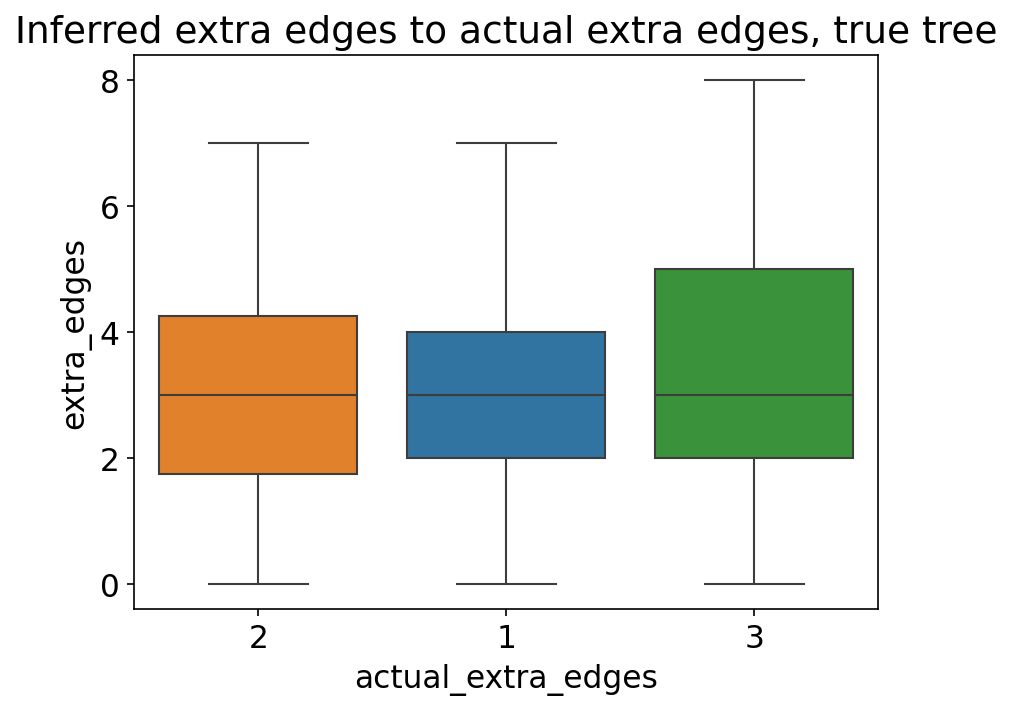

In [ ]:
fig, ax = plt.subplots(1,1)
true_tree_df = df_logs[df_logs['method'] == 'True Tree']
sns.boxplot(
    data = true_tree_df,
    x = 'factor',
    y = 'extra_edges',
    order = FACTORS,
    hue = 'actual_extra_edges',
    hue_order = ["1","2","3"],
    ax=ax
)

ax.set_title("Inferred extra edges to actual extra edges, true tree")
fig.savefig(LN / "figs" / "infxtra-actextra.png")


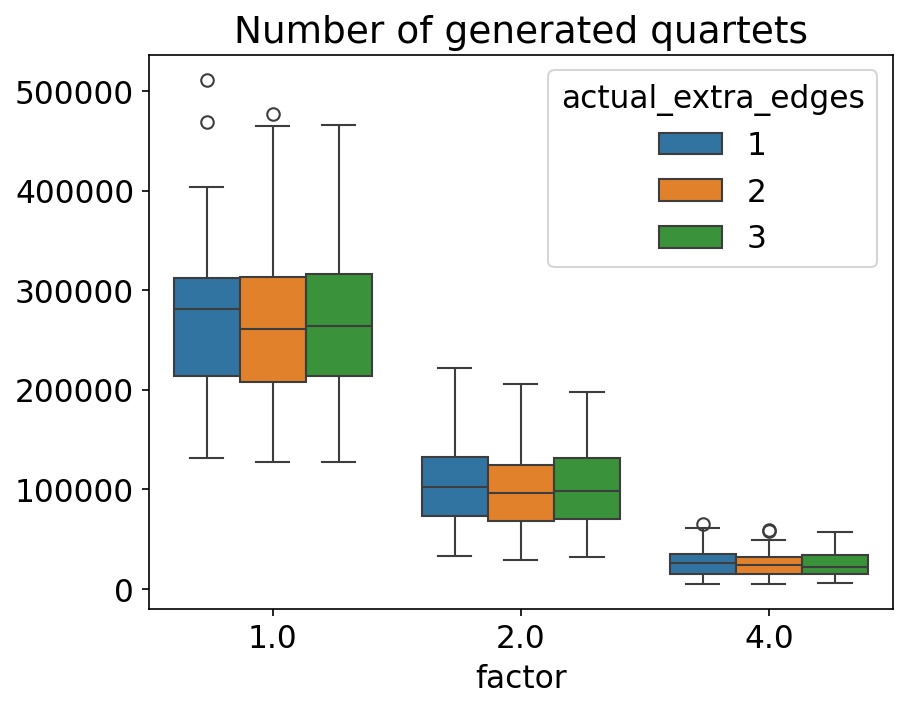

In [ ]:
fig, ax = plt.subplots(1,1)
sns.boxplot(
    data = true_tree_df,
    x = 'factor',
    y = 'tot_quartets',
    order = FACTORS,
    hue = 'actual_extra_edges',
    hue_order = ["1","2","3"],
    ax=ax
)

ax.set_title("Number of generated quartets")
ax.set_ylabel("")
fig.savefig(LN / "figs" / "ngen-quartets.png")
